In [36]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ipywidgets import Image
from IPython import display
import seaborn as sns
%matplotlib widget


In [37]:
w1data = pd.read_csv("nfl-big-data-bowl-2023/week1.csv")
w1data.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None


In [38]:
def collect_game_info(weekdf, playId, saved=False):
    
    #slice df to single play
    playdf = weekdf.loc[weekdf["playId"] == playId]
    #reorder playdf so that they are in the right frame order
    playdf = playdf.sort_values(by = "frameId")
    if saved:
        playdf.to_csv(f'Play{playId}Frames.csv')
    return playdf

In [39]:
collect_game_info(w1data, 90,True)

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
377637,2021091204,90,41251.0,1,2021-09-12T17:07:23.400,2.0,SF,left,73.56,15.30,1.04,0.97,0.11,74.46,34.20,None
377676,2021091204,90,41256.0,1,2021-09-12T17:07:23.400,1.0,SF,left,60.02,26.23,0.05,0.57,0.00,84.21,159.84,None
378222,2021091204,90,47791.0,1,2021-09-12T17:07:23.400,88.0,DET,left,76.60,18.80,1.84,1.94,0.19,283.77,343.82,None
377949,2021091204,90,44947.0,1,2021-09-12T17:07:23.400,30.0,DET,left,82.96,25.96,0.00,0.00,0.00,283.66,100.51,None
378339,2021091204,90,48455.0,1,2021-09-12T17:07:23.400,67.0,DET,left,76.40,29.12,0.00,0.00,0.00,258.99,88.78,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377870,2021091204,90,43290.0,39,2021-09-12T17:07:27.200,16.0,DET,left,85.00,33.71,5.86,1.46,0.59,339.16,8.39,None
377792,2021091204,90,42389.0,39,2021-09-12T17:07:27.200,3.0,SF,left,81.03,13.03,1.04,2.80,0.09,346.29,321.94,None
378377,2021091204,90,48455.0,39,2021-09-12T17:07:27.200,67.0,DET,left,76.72,23.42,1.97,1.31,0.20,230.09,333.73,None
378182,2021091204,90,46424.0,39,2021-09-12T17:07:27.200,45.0,DET,left,83.15,17.48,1.11,0.78,0.11,248.55,129.75,None


C:\Users\Theo\AppData\Local\Temp/ipykernel_4588/252879036.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.play_df['frameId'] = self.play_df['frameId'].astype('int')


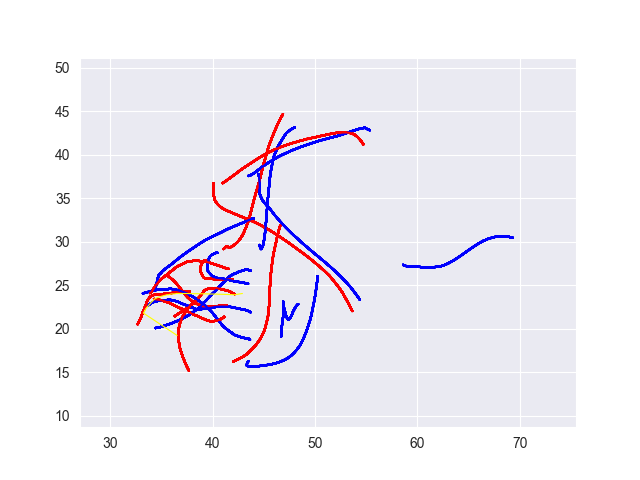

In [40]:
class Animation:
    def __init__(self, weekdf, playId):
        # Get the play info
        play = collect_game_info(weekdf, playId)
        self.play_df = play.dropna()
        self.ball_df = play[play['team'] == 'football']

        # convert frameId to integer values
        self.play_df['frameId'] = self.play_df['frameId'].astype('int')

        # Reindex to players and frames (these are what we're plotting over)
        self.player_df = self.play_df.set_index(['jerseyNumber', 'frameId'])
        self.ball_df = self.ball_df.set_index(['jerseyNumber', 'frameId'])
        self.num_frames = len(self.play_df['frameId'].unique())
        self.num_players = len(self.play_df['jerseyNumber'].unique())
        self.teams = self.player_df['team'].unique()

        # Get team colours (so far this is just random, eventually should be attacking team is always same colour)
        self.team_cols = {self.teams[0]:'red', self.teams[1]:'blue'}

        # Plotting range with some padding
        self.xrange = (self.player_df['x'].min()-5, self.player_df['x'].max()+5)
        self.yrange = (self.player_df['y'].min()-5, self.player_df['y'].max()+5)

        self.fig = plt.figure()
        self.axes = plt.axes(xlim=self.xrange, ylim=self.yrange)


        # Trajectory initialisation (for animation)
        self.trajs = []
        for index in range(self.num_players):
            l_object = self.axes.plot([],[])
            self.trajs.append(l_object[0])

    def init_frame(self):
        for traj in self.trajs:
            traj.set_data([],[])
        return self.trajs

    def frame(self, i):
        print(f'Frame {i+1}/{self.num_frames}\r', end="")
        # get the trajectories for each jerseyNumber from frameId 0->i
        self.axes.clear()
        plt.axis('off')
        self.axes = plt.axes(xlim=self.xrange, ylim=self.yrange)

        # Find the trajectories (xs and ys before frame i)
        player_trajs = self.player_df[self.player_df.index.get_level_values('frameId').isin(range(1, i+1))] # bruh

        ball_traj = self.ball_df[self.ball_df.index.get_level_values('frameId').isin(range(1, i+1))]



        # Plot each players trajectory
        for loop_index, traj_index in enumerate(player_trajs.index):
            jersey_number, frame_number = traj_index
            pos_df = player_trajs.loc[jersey_number][['x', 'y', 'team']]
            # get the colour of the player based off their team (again this will change later to attacking/defending rather than team)
            colour = self.team_cols[pos_df['team'][1]]
            self.axes.plot(pos_df['x'], pos_df['y'], c=colour)

        self.axes.plot(ball_traj['x'], ball_traj['y'], c='yellow', linewidth=0.8)



    def animate(self):
        anim = animation.FuncAnimation(self.fig,func=self.frame, init_func=self.init_frame,
                      frames=self.num_frames, interval=1, blit=True)
        return anim
anim = Animation(w1data, 97).frame(40)

C:\Users\Theo\AppData\Local\Temp/ipykernel_4588/252879036.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.play_df['frameId'] = self.play_df['frameId'].astype('int')


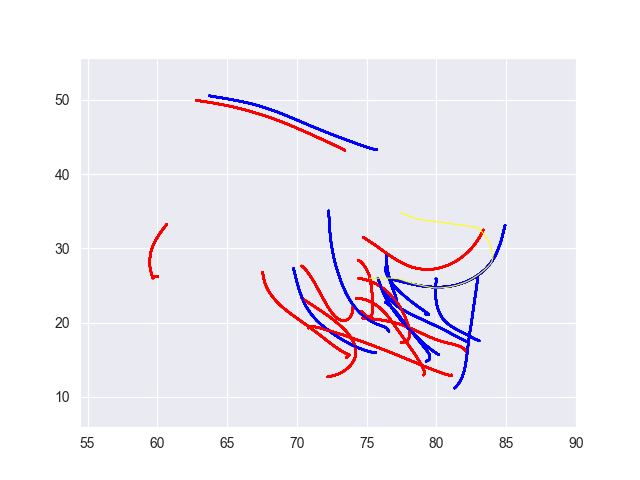

In [41]:
play_num=90
anim = Animation(w1data, play_num).animate()
path = f'gifs/{play_num}.gif'
writergif = animation.PillowWriter(fps=10)
anim.save(path, writer=writergif)


In [ ]:
file = open(path , "rb")
image = file.read()
progress= Image(
    value=image,
    format='gif',
    width=500,
    height=500)
display.display(progress)